# Understanding Customer Sentiments Towards Airlines 

By Hannah Koschmeder, Sophia Yoo, Bryan Yan

## Table of Contents
1. [Introduction](#Introduction)
2. [Getting the Data](#Getting the Data)
3. [EDA](#EDA)
    4. [Bar Graph](#Bar Graph)
    5. [Time Series](#Time Series)
    6. [Word Clouds](#Word Clouds)
7. [Clustering and Classifying Tweets](#Clustering and Classifying Tweets)
    8. [Data Preparation](#Data Preparation)
    9. [Training Doc2Vec Model](#Training Doc2Vec Model)
    10. [Hand Labeled](#Hand Labeled)
11. [Naive Bayes](#Naive Bayes)

<a id='Introduction'></a>

## Introduction

Twitter is a great source of customer sentiment because it is public, has numerous users, and allows users to express their sentiment freely. For this project we were interested in discovering sentiments towards American-based airlines. We chose to study the top 7 airlines based on [this article](https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America). We decided to use tweets to discover an airline's overall reputation, and what factors might be causing the positive or negative reputations of these airlines.
<n></n>
In this project we scraped 5,000 tweets about each airline from the past few years using an unofficial Twitter scraper. Next, we rated the polarity of the sentiment of each tweet using a library called TextBlob, and classified each tweet as negative, neutral, or positive. During our exploratory data analysis, we discovered more positive and neutral tweets than expected, which made us question the accuracy of TextBlob. However, we also were able to find key, current events, at the most times of increases in negative tweet sentiment, which was a good sign for TextBlob's classifications. Next, we made word clouds for positive, negative, and neutral classifications which gave us a better idea of key words in our dataset. Now, that we had a better idea of the insights contained in our dataset, we decided to find relevant tweets to our some key factors we identified, which would show exactly what an airline might be doing well or need to improve on.

In [24]:
import numpy as np
import pandas as pd
import math
import csv
import re
from textblob import TextBlob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import textwrap

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

<a id='Getting the Data'></a>

## Getting the Data

Although Twitter has an official API, it has many limitations which would not allow us to scrape as many tweets from previous years as we would like. Because of this, we will be using an unofficial scraper, which can be found [here](https://github.com/taspinar/twitterscraper), and installed using pip.

`pip install twitterscraper`

Run the following command for each airline to retrieve the results and save them in separate CSV files:

` twitterscraper "to:united" -o united.csv -l 5000 -c`

We chose to look at the top 7 airlines within North America.
* Alaska Airlines
* American Airlines
* Delta Airlines
* JetBlue Airlines
* SouthWest Airlines
* Spirit Airlines
* United Airlines

Next, to clean and assemble our data we removed mentions of other users, urls, and added a column to identify which airline the tweet had been about.

In [25]:
airline_df = pd.DataFrame()
airlines = ['alaska', 'american', 'delta', 'jetblue', 'southwest', 'spirit', 'united']
filenames = ["data/alaska.csv", "data/american.csv",
             "data/delta.csv", "data/jetblue.csv",
             "data/southwest.csv", "data/spirit.csv",
             "data/united.csv"]

for filename in filenames:
    file = pd.read_csv(filename)
    file['airline'] = filename.split('/')[1][:-4]
    airline_df = airline_df.append(file)

airline_df = airline_df.drop(['url','html'], axis=1)

In [26]:
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_urls(text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', text)

def cleanTweet(tweet):    
    noURLs = remove_urls(tweet)
    noMentions = remove_mentions(noURLs)
    return noMentions.lower().strip()

airline_df['text'] = airline_df['text'].apply(lambda x: cleanTweet(str(x)))
airline_df.head(5)

,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline
0,rkdasaka,ravi dasaka,841431041906634753,2017-03-13 23:29:28,0,0,0,#mostwestcoast,alaska
1,KyleCDavidson,kyle davidson,841428140383588352,2017-03-13 23:17:56,0,0,0,3rd cancelled flight of my vacay & now just hu...,alaska
2,mr_deals805,o,841411760015859714,2017-03-13 22:12:50,0,0,0,people from kansas city...not people from san ...,alaska
3,lilcadet101,Cadet,841409697089486849,2017-03-13 22:04:39,0,0,0,i'll take an $800 voucher to give up my seat f...,alaska
4,karenjen75,MomOf3Boys,841408802964484096,2017-03-13 22:01:05,0,0,0,"- hands down, the best airline in customer ser...",alaska


To get the sentiments of every tweet, we will be using a library called [TextBlob](http://textblob.readthedocs.io/en/dev/index.html). TextBlob assigns values between -1 (most negative) and 1 (most positive). We classified each tweet as positive, negative, or neutral using their TextBlob polarity.

In [27]:
def get_sentiment(text):
    tb = TextBlob(str(text))
    return tb

def getClassification(polarity):
    if (polarity < 0): return 'negative'
    elif (polarity > 0): return 'positive'
    else: return 'neutral'

airline_df['sentiment_polarity'] = airline_df['text'].apply(lambda x: get_sentiment(x).sentiment.polarity)
airline_df['sentiment'] = airline_df['sentiment_polarity'].apply(lambda x: getClassification(x))
airline_df.head(10)

,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline,sentiment_polarity,sentiment
0,rkdasaka,ravi dasaka,841431041906634753,2017-03-13 23:29:28,0,0,0,#mostwestcoast,alaska,0.000000,neutral
1,KyleCDavidson,kyle davidson,841428140383588352,2017-03-13 23:17:56,0,0,0,3rd cancelled flight of my vacay & now just hu...,alaska,-0.375000,negative
2,mr_deals805,o,841411760015859714,2017-03-13 22:12:50,0,0,0,people from kansas city...not people from san ...,alaska,0.000000,neutral
3,lilcadet101,Cadet,841409697089486849,2017-03-13 22:04:39,0,0,0,i'll take an $800 voucher to give up my seat f...,alaska,0.000000,neutral
4,karenjen75,MomOf3Boys,841408802964484096,2017-03-13 22:01:05,0,0,0,"- hands down, the best airline in customer ser...",alaska,0.422222,positive
5,jaustinw,J. Austin Wulliman,841406203695587328,2017-03-13 21:50:46,1,1,0,". wait, how could you tell i was blazed when ...",alaska,0.000000,neutral
6,TheeBenReed,Benjamin Reed,841404048699973632,2017-03-13 21:42:12,0,1,0,first time flying and already a 2 hr. flight ...,alaska,0.250000,positive
7,michaelnoll11,Michael Noll,841395450221490176,2017-03-13 21:08:02,0,1,0,upcoming vx flight (i'm elevate silv and mvp)....,alaska,0.000000,neutral
8,nielsenc,C Nielsen,841395144528019456,2017-03-13 21:06:49,0,1,0,why does an employee non-rev board early (befo...,alaska,0.157143,positive
9,badnewscaitie,caitie,841394528909172737,2017-03-13 21:04:22,0,1,0,"this is a six and a half hour flight, how on e...",alaska,-0.166667,negative


<a id='EDA'></a>

## EDA

## Sentiment Distribution Histogram

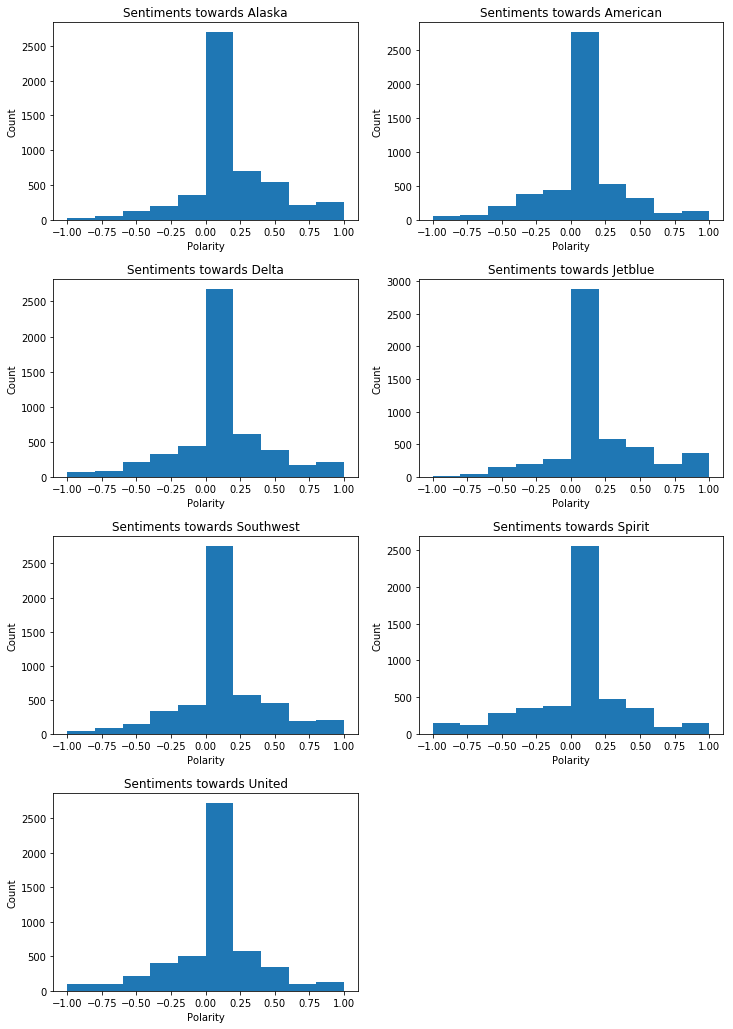

In [28]:
def plot_histogram(df, airline, name, xlabel):
    subset = df[df['airline'] == airline]
    allValues = subset[name]
    plt.hist(allValues)
    plt.title('Sentiments towards ' + airline.capitalize())
    plt.xlabel(xlabel)
    plt.ylabel('Count')

plt.figure(figsize=(12,32))
name = 'sentiment_polarity'
label = 'Polarity'

for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.3)
    plot_histogram(airline_df, airline, name, label)

<a id='Bar Graph'></a>

## Sentiment Distribution Bar Chart
To check that we had a balanced sample of tweets, we plotted the percentages of positive, negative, and neutral tweets for each airline. We were surprised to find that there were often more neutral and positive tweets than negative tweets, as Twitter is usually known for users complaining publicly about their poor experiences on flights. However, we generated 5 random rows of each sentiment and discovered that they were mostly accurate. Sarcasm used in negative tweets is classified as positive, and some overall negative tweets were classified as positive.

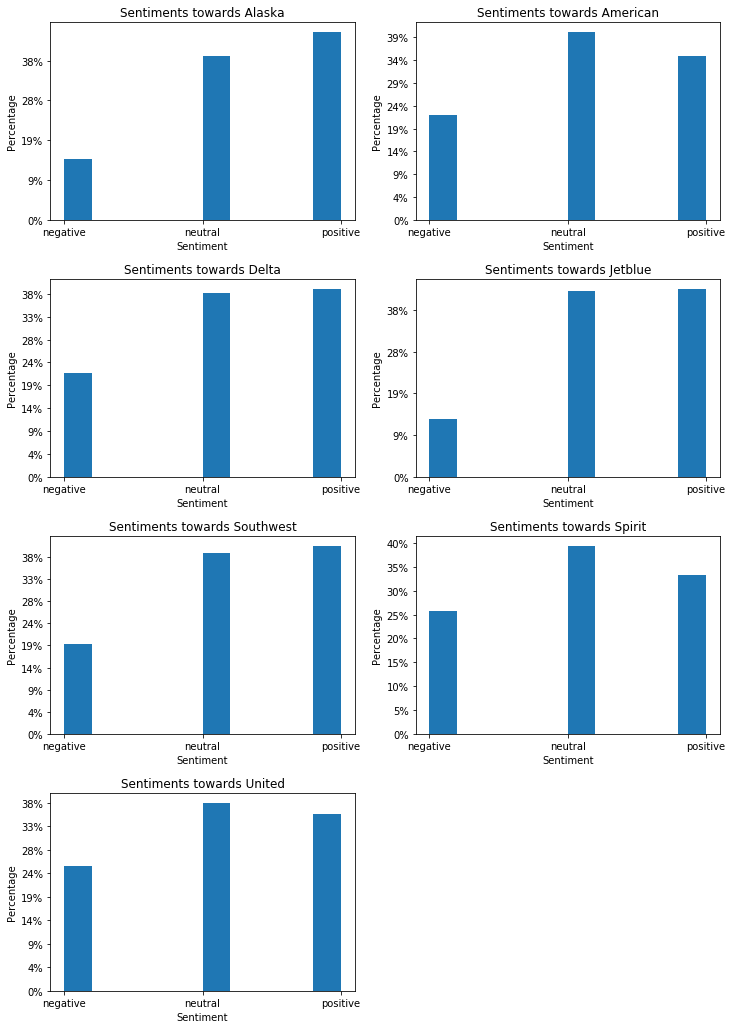

In [29]:
def plotHistogram(df, airline, name, xlabel):
    subset = df[df['airline'] == airline]
    allValues = subset[name]
    plt.hist(allValues)
    formatter = FuncFormatter(lambda y, pos: "%d%%" % (y/len(allValues) * 100))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.title('Sentiments towards ' + airline.capitalize())
    plt.xlabel(xlabel)
    plt.ylabel('Percentage')

plt.figure(figsize=(12,32))
name = 'sentiment'
label = 'Sentiment'
for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.3)
    plotHistogram(airline_df, airline, name, label)

In [30]:
# Get some neutral tweets
print("Neutral Tweets")
neutralTweets = airline_df[airline_df['sentiment'] == 'neutral']
neutralTweets.head(5)['text'].apply(lambda x: print ("    *",textwrap.indent(textwrap.fill(x, 80),"  ")))
print("\n")
# Get some positive tweets
print("Positive Tweets")
positiveTweets = airline_df[airline_df['sentiment'] == 'positive']
positiveTweets.head(5)['text'].apply(lambda x: print ("    +",textwrap.indent(textwrap.fill(x, 80),"  ")))
print("\n")
# Get some negative tweets
print("Negative Tweets")
negativeTweets = airline_df[airline_df['sentiment'] == 'negative']
negativeTweets.head(5)['text'].apply(lambda x: print("    -",textwrap.indent(textwrap.fill(x, 80),"  ")))

Neutral Tweets
    *   #mostwestcoast
    *   people from kansas city...not people from san francisco!
    *   i'll take an $800 voucher to give up my seat from boston to san diego #kappa
    *   .  wait, how could you tell i was blazed when i tweeted that?!?
    *   upcoming vx flight (i'm elevate silv and mvp). if i use my elevate number on the
  flight how will i get miles for next year's mvp?


Positive Tweets
    +   - hands down, the best airline in customer service on the planet.
    +   first time flying  and already a 2 hr. flight delay....
    +   why does an employee non-rev board early (before 1st) and brings on large bag
  while begging to check bags?
    +   great day to leave the wet coast and head to kona #alaskaairlines
  pic.twitter.com/bpqws48kuh
    +   hi alaska! i'm trying to get in touch with your marketing team about a
  partnership opportunity. will you dm the right e-mail?


Negative Tweets
    -   3rd cancelled flight of my vacay & now just hung up on me afte

1     None
9     None
18    None
26    None
30    None
Name: text, dtype: object

<a id='Time Series'></a>

## Time Series Observations
We used time series plots to show peaks in negative sentiment tweets. We performed some simple internet searches and found some major news stories that might be the source of the increase in negative tweets at these times. However, some peaks in negative tweets had no single news story or sometimes had no news story at all.

In [31]:
#change timestamp to datetime object
airline_df['timestamp'] = airline_df['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

/Users/hannahkoschmeder/anaconda3/envs/original/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


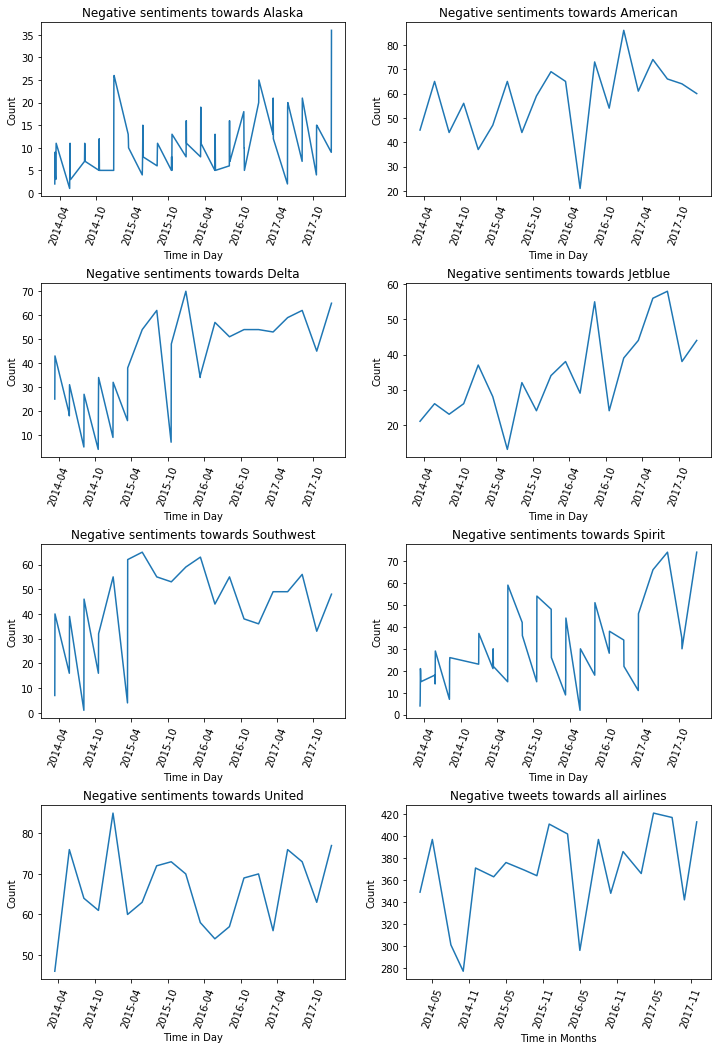

In [32]:
#plot negative tweets over time by airline
def plotTimeSeries(df, airline, sentiment, day=True):
    if airline==None:
        subset = df[df['sentiment']==sentiment]
    else:
        subset = df[df['airline'] == airline]
        subset = subset[subset['sentiment'] == sentiment]
    xlab = "Day"
    if not day:
            subset['timestamp'] = subset['timestamp'].apply(lambda x: x.replace(day=1))
            xlab = "Months"
    allValues = pd.DataFrame({'timestamp':subset['timestamp'],'counts':subset['timestamp']})
    allValues = allValues.groupby('timestamp').count()
    plt.plot(allValues.index, allValues['counts'])
    if airline != None:
        plt.title(sentiment.capitalize() + ' sentiments towards '  + airline.capitalize())
    else:
        plt.title(sentiment.capitalize() + " tweets towards all airlines")
    plt.xticks(rotation=70)
    plt.xlabel("Time in " + xlab)
    plt.ylabel('Count')
    

plt.figure(figsize=(12,32))
name = 'negative'
for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.5)
    plotTimeSeries(airline_df, airline, name, True)
plt.subplot(7,2,8)
plt.subplots_adjust(hspace = 0.5)
plotTimeSeries(airline_df, None, "negative", False)

<a id='Word Clouds'></a>

## Word Clouds

We generated word clouds to identify key words in each sentiment of our tweets, removing the airline names as stopwords. We also generated word clouds for each airline. This gave us a good idea of which words were important and helped us in the next step to generate our categories.

In [33]:
def generateWordClouds(df, colname, stopwords):
    unique = list(pd.unique(df[colname]))
    wordclouds = dict()
    for i, value in enumerate(unique):
        subset = df.loc[df[colname] == value]
        wc = WordCloud(width = 800, height = 400,
                      background_color='white', stopwords=stopwords).generate(str(subset['text']))
        wordclouds[value] = wc
    return wordclouds

def plot_image(im):
    plt.imshow(np.asarray(im))
    
tweet_stopwords = set(['thank', 'thanks', 'airline', 'flight', 'airline', 'plane', 'airlines', 'alaska',
                      'americanairlines', 'delta', 'alaskaairlines', 'southwest', 'unitedairlines', 'jetblue',
                      'twitter', 'get'])
stopwords = set(stop_words | tweet_stopwords)

sentiment_wcs = generateWordClouds(airline_df, 'sentiment', stopwords)
airline_wcs = generateWordClouds(airline_df, 'airline', stopwords)

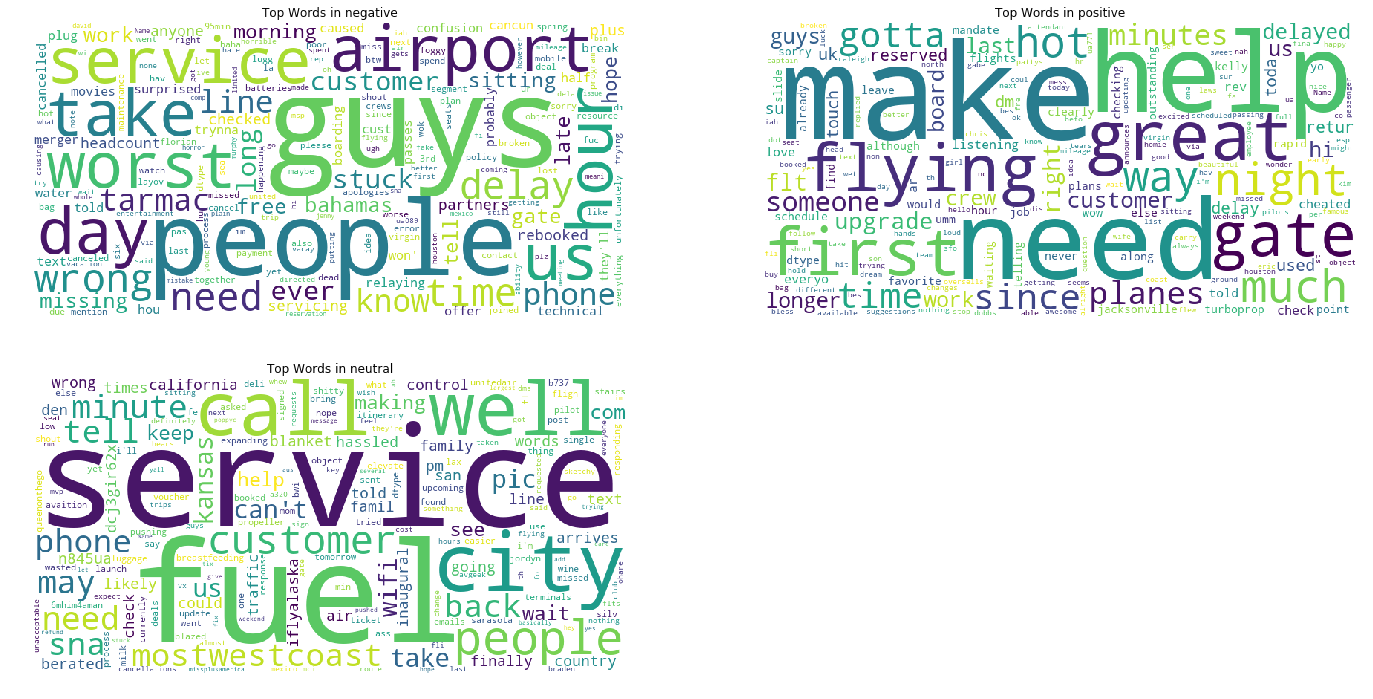

In [34]:
plt.figure(figsize=(24, 12))
i = 0
for sentiment, wc in sentiment_wcs.items():
    plt.subplot(2, 2, i+1)
    plt.title("Top Words in " + sentiment)
    plt.axis('off')
    plot_image(wc)
    i += 1

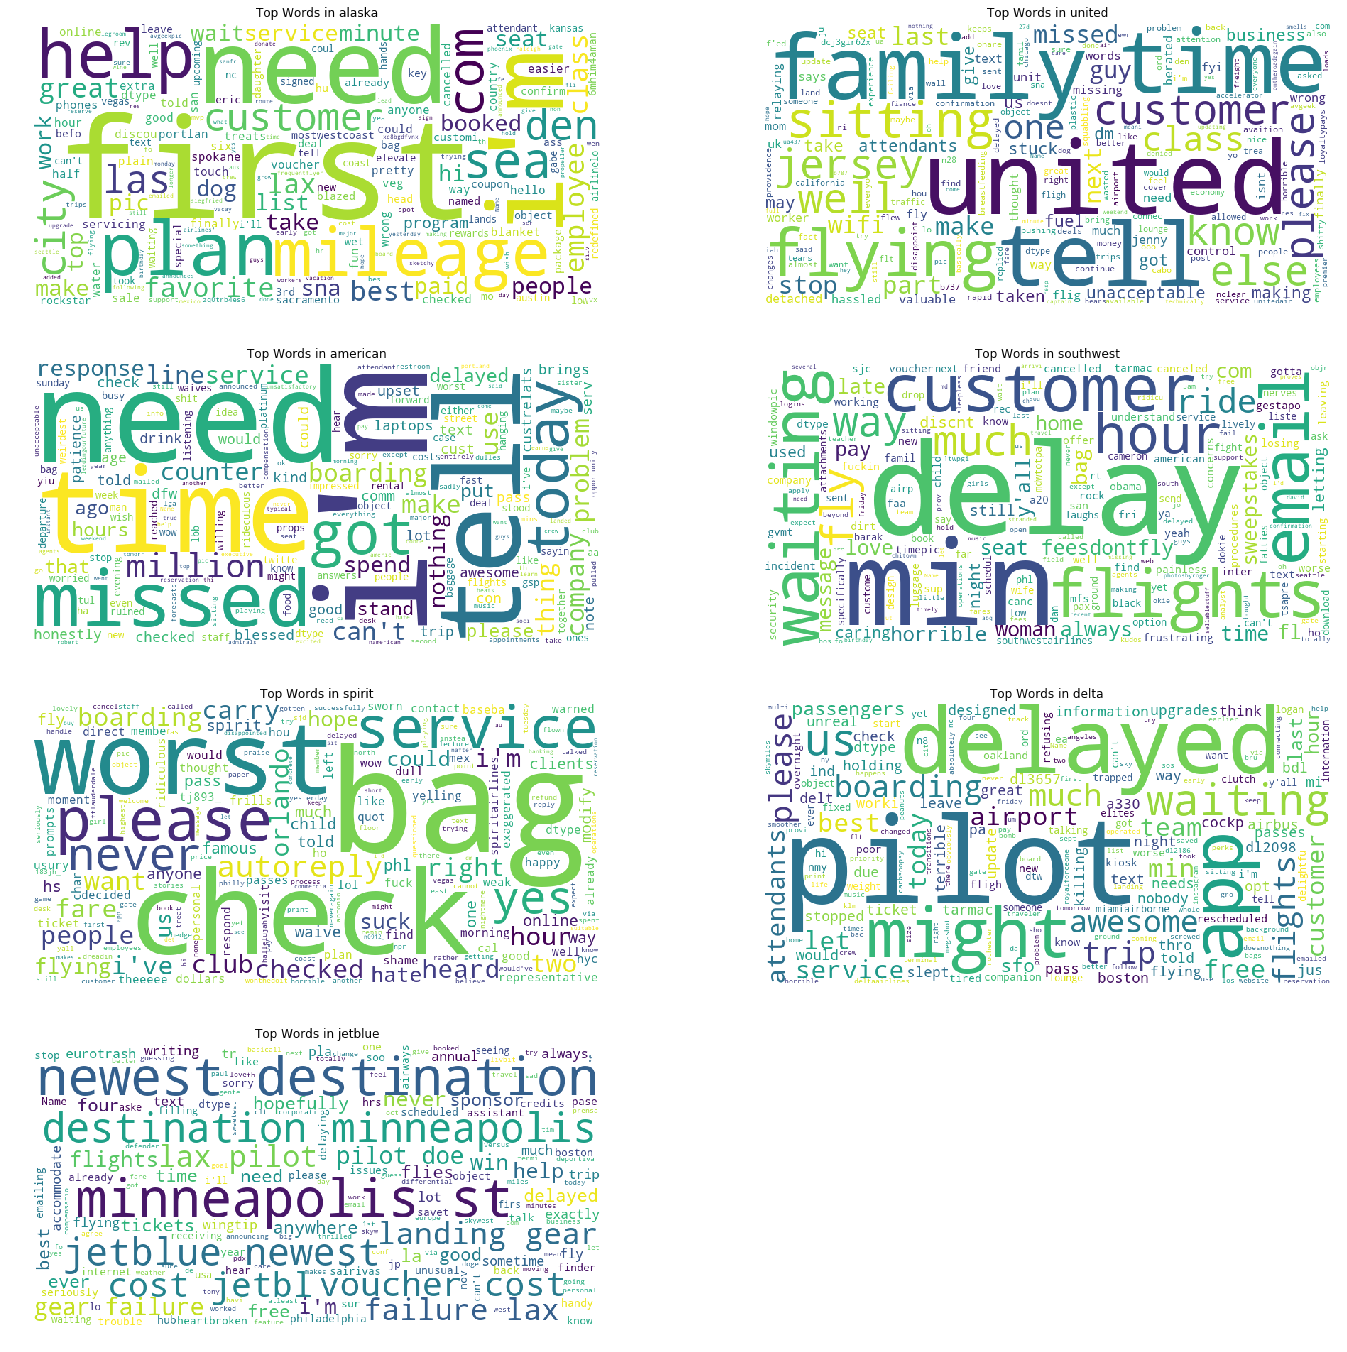

In [35]:
plt.figure(figsize=(24, 24))
i = 0
for sentiment, wc in airline_wcs.items():
    plt.subplot(4, 2, i+1)
    plt.title("Top Words in " + sentiment)
    plt.axis('off')
    plot_image(wc)
    i += 1

<a id='Clustering and Classifying Tweets'></a>

## Clustering and Classifying Tweets

<a id='Data Preparation'></a>

### Data Preparation

* tokenize 
* split train + test set

In [38]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def remove_numbers(text):
    return re.sub(r'[\d]', '', text)

def process_tokens(tweet):
    noNumbers = remove_numbers(tweet)
    tokens = nltk.word_tokenize(noNumbers)
    filtered_words = [word for word in tokens if (word not in stop_words)]
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_words]
    non_stop = [re.sub('[^A-Za-z0-9]+', '', lemma) for lemma in lemmas if (lemma not in tweet_stopwords and lemma != "http")]
    final = [word for word in non_stop if len(word) > 2]
    return final

airline_df['tokens'] = airline_df['text'].apply(lambda x: process_tokens(x))
airline_df.tail()

,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline,sentiment_polarity,sentiment,tokens
5195,griffinhill1997,Griffinator,576734335774126080,2015-03-14,0,0,0,i just wasted almost $10 on your shitty wifi #...,united,0.00,neutral,"[wasted, almost, shitty, wifi]"
5196,houseofpickles,Rhia,576732782266839041,2015-03-14,0,1,0,thanks. you guys need to work out some better ...,united,0.35,positive,"[guy, need, work, better, arrangement, code, s..."
5197,katiesmiledoc,Katie Graber,576731313178312704,2015-03-14,0,0,0,just replied via dm. thanks for the rapid resp...,united,0.20,positive,"[replied, via, rapid, response, customerexperi..."
5198,huntmayo,Hunt Mayo,576730512221302784,2015-03-14,0,0,0,#b737 pushing back #avgeek #avaition #flying ...,united,0.00,neutral,"[pushing, back, avgeek, avaition, flying, plan..."
5199,ashknierim,Ashley Knierim,576728675367927808,2015-03-14,0,0,0,when do you post last minute weekend deals?,united,0.00,neutral,"[post, last, minute, weekend, deal]"


<a id='Training Doc2Vec Model'></a>

### Training Doc2Vec Model

We will be using the `gensim` library in Python to train a Doc2Vec model. In order to do so, we need to create a list of `TaggedDocument`s, which are in the format `[word = [token1, token2, token3, ..], tags = [tag]]`. We feed a list of `TaggedDocument`s to the model, and train it.

In [39]:
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

TaggedTweet = gensim.models.doc2vec.TaggedDocument

tweets = [TaggedTweet(x, [i]) for i, x in enumerate(airline_df['tokens'])]
model = Doc2Vec(min_count=1, window=10, vector_size=100, sample=1e-4, workers=8)
model.build_vocab(tweets)

In [40]:
total = len(tweets)
model.train(tweets, total_examples=total, epochs = 10, start_alpha=0.002, end_alpha=-0.016)

Using the word2vec model that we generated, we can check word similarities. For example, there are the top 20 similar words for the word "fuel."

In [41]:
model.wv.most_similar('issue', topn=20)

[('time', 0.9999983906745911),
 ('bag', 0.9999982714653015),
 ('back', 0.999998152256012),
 ('para', 0.9999980926513672),
 ('day', 0.9999980926513672),
 ('gate', 0.9999980330467224),
 ('service', 0.9999979734420776),
 ('hour', 0.9999979734420776),
 ('crew', 0.9999979138374329),
 ('spirit', 0.9999978542327881),
 ('que', 0.9999977946281433),
 ('new', 0.9999977350234985),
 ('airport', 0.9999977350234985),
 ('like', 0.9999976754188538),
 ('airplane', 0.9999976754188538),
 ('would', 0.999997615814209),
 ('min', 0.999997615814209),
 ('got', 0.999997615814209),
 ('ticket', 0.999997615814209),
 ('please', 0.999997615814209)]

We can also get most similar sentences given a certain row of data. Here, we're looking at the tweets most similar to "all flights full nothing working this is awful."

Looking at these specific tweets, we can see that some of them are misclassified. For example, "do you plan  me for making me sit in a broken faulty seat for a 3 hour flight duct tape doesn’t really seem adequate" is labeled as positive, and "all my flights were smooth sailing but over a 30 minute wait to deplane then another 40 minute wait for bags is not acceptable" was also labeled as positive, when they were both clearly negative.

In [42]:
similar = model.docvecs.most_similar(2022, topn=5)
print(list(airline_df['text'])[2022], list(airline_df['sentiment'])[2022])
for i, p in similar:
    print("Tweet: ", list(airline_df['text'])[i])
    print("Sentiment: ", list(airline_df['sentiment'])[i])

reconfigure a pkg once our flight is cancelled? your phone reps send call to flight res and they tell us to talk to vacations. neutral
Tweet:  autoreply//bd486_[legroom]: our cozy cabins save you money  pic.twitter.com/5sirryqq0o
Sentiment:  negative
Tweet:  some lucky zipsters might just find themselves with  swag or rt tix. take a #ziptrip & test your luck:
Sentiment:  positive
Tweet:  thanks ! your checkin staff was so-so but the in-flight crew is already making us ugly cackle. pic.twitter.com/zjcsjxi8zt
Sentiment:  negative
Tweet:  'unable to substantiate' lena dunham complaint over 'transphobic' employees - breitbart news :
Sentiment:  negative
Tweet:  things are looking brighter! #thanks#deltaairlines #stayingpositive #bye#miami #travelbug…
Sentiment:  neutral


Because `TextBlob` isn't able to understand sarcasm in Tweets and misclassifies a lot of the tweets, we decided to try clustering the points based on the `Doc2Vec` model we just created. We will be using the `KMeans` package from `sklearn` to get the k-means model.

In [43]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100)  
X = kmeans_model.fit(model.docvecs.vectors_docs)
labels = kmeans_model.labels_.tolist()

# try predicting
l = kmeans_model.fit_predict(model.docvecs.vectors_docs)

Results:

In [44]:
from collections import Counter
def get_cluster_tweets(clust):
    res = []
    for i in range(len(labels)):
        if labels[i] == clust:
            res.append(i)
    return res

def get_words(tweets, cluster_labs):
    res = []
    for i in cluster_labs:
        if type(tweets[i]) is not list:
            res.append(tweets[i])
        else:
            res += tweets[i]
    return res


cluster1_words = Counter(get_words(list(airline_df['tokens']), get_cluster_tweets(0)))
cluster2_words = Counter(get_words(list(airline_df['tokens']), get_cluster_tweets(1)))
cluster3_words = Counter(get_words(list(airline_df['tokens']), get_cluster_tweets(2)))

cluster1_tweets = get_words(list(airline_df['text']), get_cluster_tweets(0))
cluster2_tweets = get_words(list(airline_df['text']), get_cluster_tweets(1))
cluster3_tweets = get_words(list(airline_df['text']), get_cluster_tweets(2))

cluster1_sentiment = Counter(get_words(list(airline_df['sentiment']), get_cluster_tweets(0)))
cluster2_sentiment = Counter(get_words(list(airline_df['sentiment']), get_cluster_tweets(1)))
cluster3_sentiment = Counter(get_words(list(airline_df['sentiment']), get_cluster_tweets(2)))

print(cluster1_words.most_common()[0:10])
print(cluster2_words.most_common()[0:10])
print(cluster3_words.most_common()[0:10])

print(cluster1_tweets[1:5])
print(cluster2_tweets[1:5])
print(cluster3_tweets[1:5])

[('service', 512), ('time', 472), ('bag', 459), ('customer', 443), ('hour', 380), ('seat', 344), ('airport', 341), ('fly', 340), ('like', 330), ('new', 317)]
[('deltaairlines', 79), ('southwestairlines', 70), ('que', 63), ('spiritairlines', 63), ('bag', 61), ('united', 52), ('seat', 50), ('new', 49), ('service', 49), ('time', 48)]
[('hour', 1463), ('time', 1423), ('service', 1256), ('customer', 1181), ('bag', 1170), ('please', 1066), ('delayed', 1047), ('help', 966), ('seat', 929), ('one', 876)]
['this is a six and a half hour flight, how on earth are there no screens available?pic.twitter.com/l6i3dwjewx', "what's it cost in flight for a blanket guys? did we stop providing blankets to our elders & passengers w/health issues?", 'great day to leave the wet coast and head to kona #alaskaairlines pic.twitter.com/bpqws48kuh', '- my  is mexico city!pic.twitter.com/6mhim4aman']
['will use the a320 to launch the largest single-market expansion in the carrier’s storied history. ► pic.twitter.co

Talk about clustering of points

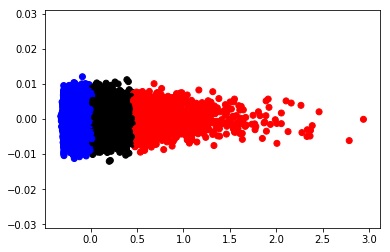

In [45]:
label1 = ["black", "red", "blue"]
color = [label1[i] for i in labels]

pca = PCA(n_components=3).fit(model.docvecs.vectors_docs)
datapoint = pca.transform(model.docvecs.vectors_docs)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
plt.show()

<a id='Hand Labeled'></a>

## Hand Labeled


In [46]:
labeled_df = pd.read_csv("data/handLabel.csv")
labeled_df.head()

,Unnamed: 0,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline,sentiment_polarity,sentiment,tokens,hand_label
0,4860,amatahammerand,Amy Hammerand,5.500510e+17,12/30/14 22:07,0,0,0,no flight credit from while my grandpa is in ...,spirit,0.000,neutral,"['flight', 'credit', 'grandpa', 'hospice', 'sw...",negative
1,3435,netcooper10,Brett P. Cooper,7.620470e+17,8/6/16 22:06,0,1,0,hi! sorry! still here,delta,-0.625,negative,"['hi', 'sorry', 'still']",neutral
2,3275,jkordyback,John Kordyback,5.761660e+17,3/12/15 23:39,0,0,0,suggestion: increase the size of the tsa pre s...,alaska,0.000,neutral,"['suggestion', 'increase', 'size', 'tsa', 'pre...",negative
3,4652,michellepego,Michelle Irene,6.558480e+17,10/18/15 20:46,0,2,0,nothing better than finding out ur flight is d...,spirit,0.500,positive,"['nothing', 'better', 'finding', 'ur', 'flight...",negative
4,838,knicks148,B. 🥌,4.442290e+17,3/13/14 21:49,0,0,0,two fees...depends if you want to sit.,spirit,0.000,neutral,"['two', 'fee', 'depends', 'want', 'sit']",negative


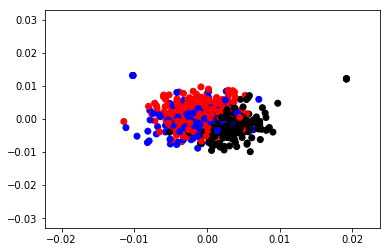

In [47]:
true_labels = list(labeled_df['hand_label'])
code_labels = list()
for lab in true_labels:
    if lab == "positive":
        code_labels.append(1)
    elif lab == "negative":
        code_labels.append(2)
    else:
        code_labels.append(0)

inf_vec = []
for i in range(611):
    inf = model.infer_vector(list(labeled_df['tokens'])[i])
    inf_vec.append(inf)

labels = kmeans_model.fit_predict(inf_vec)

label1 = ["black", "red", "blue"]
color = [label1[i] for i in labels]

pca = PCA(n_components=3).fit(inf_vec)
datapoint = pca.transform(inf_vec)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
plt.show()